In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotnine
from plotnine import ggplot, geom_histogram, aes

PATH_TO_DATA = '../data/'
PATH_TO_OUTPUT_DATA = '../output-data/'
PATH_TO_MODEL_DATA = '../model-data/'
PATH_TO_VIS_DATA = '../visualization-data/'

In [2]:
# imports
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import brier_score_loss, confusion_matrix, \
    roc_auc_score, roc_curve, auc, average_precision_score, precision_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
MLB_DF = pd.read_csv(PATH_TO_OUTPUT_DATA + 'MLB_INPUT.csv')
MLB_DF['home_ISO'] = MLB_DF['home_SLG'] - MLB_DF['home_AVG']
MLB_DF['away_ISO'] = MLB_DF['away_SLG'] - MLB_DF['away_AVG']
MLB_DF['ISO_difference'] = MLB_DF['home_ISO'] - MLB_DF['away_ISO']
MLB_DF['ISO_difference_PCT'] = (MLB_DF['home_ISO'] - MLB_DF['away_ISO'])/ MLB_DF['home_ISO']*100

In [101]:
EDA_DATA = create_features(MLB_DF, False)[0].rename(
    dict(zip(
        list(create_features(MLB_DF, False)[0].columns),
        [x.split('_difference')[0] + 'Δ' for x in create_features(MLB_DF, False)[0].columns],
    )), axis = 1
).rename({
    'restΔ%': 'restΔ'
}, axis = 1)
EDA_DATA.describe()

,OBPΔ,WHIPΔ,K9Δ,HR9Δ,K/BBΔ,FIPΔ,ELOΔ,ISOΔ,restΔ
count,46128.000000,46128.000000,46128.000000,46128.000000,46128.000000,46128.000000,46128.000000,46128.000000,46128.000000
mean,0.022602,-0.000598,0.002237,0.000093,0.005135,-0.001073,-0.112993,0.001160,0.000304
std,0.461568,0.194821,1.806960,0.382400,1.353428,0.837939,47.109015,0.057983,2.381057
min,-1.779933,-1.154770,-8.682394,-2.027936,-14.008457,-4.167378,-176.250866,-0.275342,-182.000000
25%,-0.283042,-0.114781,-1.060189,-0.222333,-0.579593,-0.490549,-31.949433,-0.037133,0.000000
50%,0.020453,0.000000,0.000000,0.000000,0.000000,0.000000,0.267419,0.001450,0.000000
75%,0.327019,0.113652,1.070891,0.222525,0.592246,0.494594,31.965614,0.039222,0.000000
max,1.960365,0.998780,9.585648,2.027936,13.964935,5.000167,193.658080,0.215447,189.000000


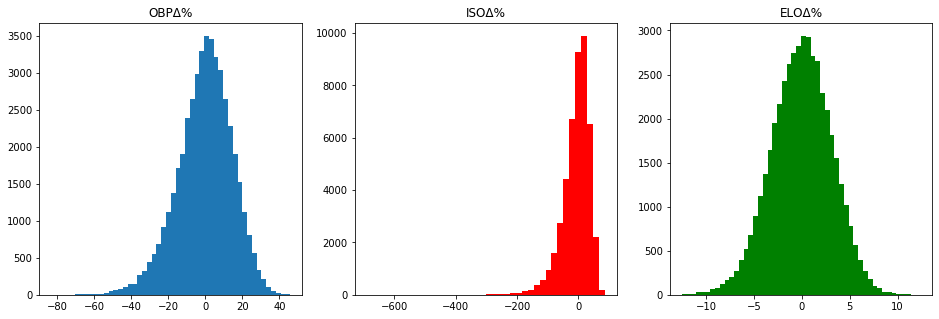

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 5))
ax1.hist(EDA_DATA['OBPΔ%'], bins = 50)
ax1.set(title = 'OBPΔ%')
ax2.hist(EDA_DATA['ISOΔ%'], bins = 40, color = 'red')
ax2.set(title = 'ISOΔ%')

ax3.hist(EDA_DATA['ELOΔ%'], bins = 50, color = 'green')
ax3.set(title = 'ELOΔ%')

plt.savefig('../charts/eda-pct.png', dpi=320)
plt.show()

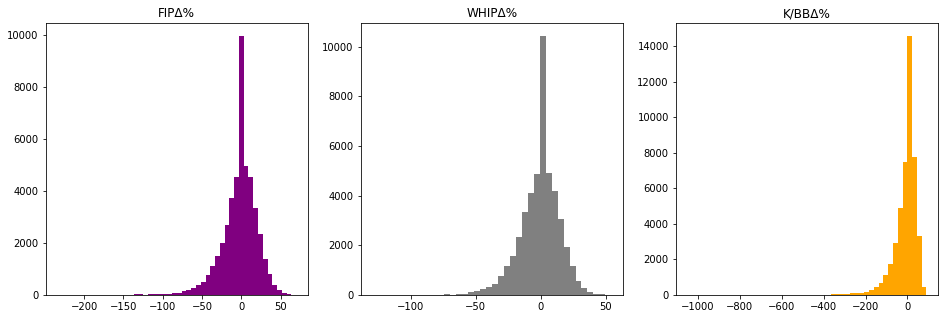

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 5))
ax1.hist(EDA_DATA['FIPΔ%'], bins = 50, color = 'purple')
ax1.set(title = 'FIPΔ%')
ax2.hist(EDA_DATA['WHIPΔ%'], bins = 40, color = 'gray')
ax2.set(title = 'WHIPΔ%')

ax3.hist(EDA_DATA['K/BBΔ%'], bins = 50, color = 'orange')
ax3.set(title = 'K/BBΔ%')

plt.savefig('../charts/eda-pct-2.png', dpi=320)
plt.show()

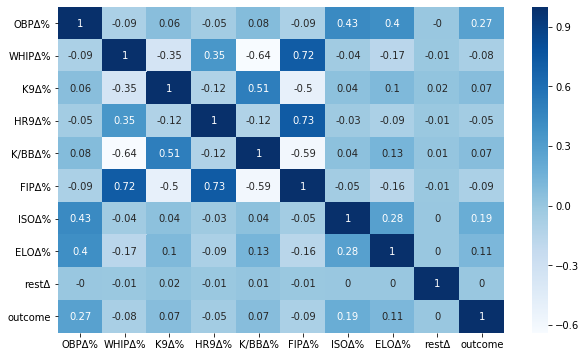

In [82]:
plt.figure(figsize=(10, 6))
cor = pd.concat([EDA_DATA, create_features(MLB_DF)[1]], axis = 1).corr()
cor = cor.apply(lambda x: round(100*x)/100)
sns.heatmap(cor, annot = True, cmap = plt.cm.Blues)
plt.savefig('../charts/eda-heatmap.png', dpi=320)
plt.show()

In [63]:
#Correlation with output variable
cor_target = abs(cor['outcome'])
# Selecting highly correlated features
relevant_features = cor_target[cor_target >= 0.1]
relevant_features

OBPΔ%      0.27
ISOΔ%      0.19
ELOΔ%      0.11
outcome    1.00
Name: outcome, dtype: float64

In [7]:
cutoff = 2015

In [94]:
def create_features(data, pct = True):
    features = data.drop(labels = 
                       ['dt', 'Y', 'M', 'D', 'away_team', 
                        'home_team', 'away_pitcher_id', 'home_pitcher_id',
                       'date'],
                      axis = 1)
    features['rest_difference'] = features['home_rest'] - features['away_rest']
    features['ELO_difference_PCT'] = features['ELO_difference']/features['home_ELO']*100
    if (pct == True):
        PCT_DIFF = features[[i for i in list(features) if 'PCT' in i] + ['rest_difference', 'outcome']]
        PCT_DIFF_features = [i for i in list(features) if 'PCT' in i] + ['rest_difference']
        PCT_DIFF.drop(labels = ['AVG_difference_PCT', 'SLG_difference_PCT', 
                            'BAA_difference_PCT', 'IP_Start_difference_PCT', 'ERA_difference_PCT'],
                 axis = 1, inplace = True)
        PCT_DIFF_features = [i for i in list(PCT_DIFF) if (i != 'outcome')]
        return PCT_DIFF[PCT_DIFF_features], PCT_DIFF['outcome']
    else:
        DIFF = features[[i for i in list(features) if 
                         (('difference' in i) and ('PCT' not in i))] + ['outcome']]
        DIFF.drop(labels = ['AVG_difference', 'SLG_difference', 'BAA_difference', 'IP_Start_difference',
                           'ERA_difference'],
                 axis = 1, inplace = True)
        DIFF_features = [i for i in list(DIFF) if (i != 'outcome')]
        return DIFF[DIFF_features], DIFF['outcome']
    
# splits season into 3/4 for train, 1/4 for test
def seasonal_train_test_split(X, Y):
    test_train_cutoff = int(len(X)*.75)
    x_train = X[0:test_train_cutoff]
    x_test = X[test_train_cutoff:]
    y_train = Y[0:test_train_cutoff]
    y_test = Y[test_train_cutoff:]
    
    return x_train, x_test, y_train, y_test

# Generate 
def create_yearly_samples(MLB_DF = MLB_DF[MLB_DF.Y > cutoff], scaling = False):
    if (scaling == True):
        pd.options.mode.chained_assignment = None
    sclr = StandardScaler()
    years = list(set(MLB_DF.Y))
    YEARLY_DATA = {}
    for i in years:
        YEARLY_MLB = create_features(MLB_DF[MLB_DF.Y == i])
#         x_train, x_test, y_train, y_test = seasonal_train_test_split(YEARLY_MLB[0], YEARLY_MLB[1])
        x = YEARLY_MLB[0]
        if (scaling == True):
            x = sclr.fit_transform(x)
         
        YEARLY_DATA[i] = {
            'x': x,
            'y': YEARLY_MLB[1],
#             'y_train': y_train,
#             'y_test': y_test
        }
    return YEARLY_DATA

In [21]:
# Create our yearly df
MLB_FINAL_DATA_SCALED = create_yearly_samples(scaling = True)
MLB_FINAL_DATA_UNSCALED = create_yearly_samples(scaling = False)

In [432]:
# Create testing DF
SCALED_ML_RESULTS = pd.DataFrame(sorted(set(MLB_DF[MLB_DF.Y > cutoff]['Y']))).rename(
    {0: 'Y'}, axis = 1).set_index('Y')
SCALED_ML_RESULTS['LogitLasso'] = 0
SCALED_ML_RESULTS['LogitRidge'] = 0
SCALED_ML_RESULTS['LogitElasticNet'] = 0
SCALED_ML_RESULTS['SVC_C10'] = 0
SCALED_ML_RESULTS['SVC_C1'] = 0
SCALED_ML_RESULTS['SVC_C0.01'] = 0
SCALED_ML_RESULTS['KNN_20_Uniform'] = 0
SCALED_ML_RESULTS['KNN_10_Uniform'] = 0
SCALED_ML_RESULTS['KNN_10_Distance'] = 0
SCALED_ML_RESULTS

,LogitLasso,LogitRidge,LogitElasticNet,SVC_C10,SVC_C1,SVC_C0.01,KNN_20_Uniform,KNN_10_Uniform,KNN_10_Distance
Y,,,,,,,,,
2016,0,0,0,0,0,0,0,0,0
2017,0,0,0,0,0,0,0,0,0
2018,0,0,0,0,0,0,0,0,0
2019,0,0,0,0,0,0,0,0,0


In [22]:
# Create testing DF
UNSCALED_ML_RESULTS = pd.DataFrame(sorted(set(MLB_DF[MLB_DF.Y > cutoff]['Y']))).rename(
    {0: 'Y'}, axis = 1).set_index('Y')
UNSCALED_ML_RESULTS['LogitLasso'] = 0
UNSCALED_ML_RESULTS['LogitRidge'] = 0
UNSCALED_ML_RESULTS['LogitElasticNet'] = 0
UNSCALED_ML_RESULTS['DecisionTree'] = 0
UNSCALED_ML_RESULTS['RF'] = 0
UNSCALED_ML_RESULTS['SGD'] = 0
UNSCALED_ML_RESULTS['XGBoost'] = 0
UNSCALED_ML_RESULTS

,LogitLasso,LogitRidge,LogitElasticNet,DecisionTree,RF,SGD,XGBoost
Y,,,,,,,
2016,0,0,0,0,0,0,0
2017,0,0,0,0,0,0,0
2018,0,0,0,0,0,0,0
2019,0,0,0,0,0,0,0


In [47]:
# Create testing DF
UNSCALED_ML_RESULTS_MONTH = pd.DataFrame(
    sorted(set(MLB_DF[MLB_DF.Y == 2019]['M']))).rename(
    {0: 'M'}, axis = 1).set_index('M')
UNSCALED_ML_RESULTS_MONTH['LogitLasso'] = 0
UNSCALED_ML_RESULTS_MONTH['LogitRidge'] = 0
UNSCALED_ML_RESULTS_MONTH['LogitElasticNet'] = 0
UNSCALED_ML_RESULTS_MONTH['DecisionTree'] = 0
UNSCALED_ML_RESULTS_MONTH['RF'] = 0
UNSCALED_ML_RESULTS_MONTH['SGD'] = 0
UNSCALED_ML_RESULTS_MONTH['XGBoost'] = 0
UNSCALED_ML_RESULTS_MONTH

,LogitLasso,LogitRidge,LogitElasticNet,DecisionTree,RF,SGD,XGBoost
M,,,,,,,
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0


## Scaled classifiers
Consider the classifiers that need to be scaled, so we use DIFF and use StandardScaling

In [434]:
X1, Y1 = create_features(MLB_DF[MLB_DF.Y <= cutoff], False)
# x_train_01, x_test_01, y_train, y_test = seasonal_train_test_split(X1, Y1) # why standrardscale when you couldn't?

# Drop ERA, AVG, SLG
sclr = StandardScaler()
X1 = sclr.fit_transform(X1)
# x_test1 = sclr.transform(x_test_01)

Build our models - use `random_state = 499` and `cv = 5` for everything

In [435]:
SCALED_ML_MODELS = {}

In [436]:
Lasso = LogisticRegressionCV(Cs = [0.1], 
                             cv = 5, random_state = 499,
                               penalty='l1',
                               solver='saga')
Ridge = LogisticRegressionCV(Cs = [0.1], 
                             cv = 5, random_state = 499,
                               penalty='l2',
                               solver='saga')
ElasticNet = LogisticRegressionCV(Cs = [0.1], 
                                  cv = 5, random_state = 499,
                               penalty='elasticnet',
                               solver='saga',
                               l1_ratios = [0.2, 0.5, 0.7, 0.8])
Lasso.fit(X1, Y1)
Ridge.fit(X1, Y1)
ElasticNet.fit(X1, Y1)

LogisticRegressionCV(Cs=[0.1], class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=[0.2, 0.5, 0.7, 0.8], max_iter=100,
                     multi_class='auto', n_jobs=None, penalty='elasticnet',
                     random_state=499, refit=True, scoring=None, solver='saga',
                     tol=0.0001, verbose=0)

In [437]:
ElasticNet.l1_ratio_

array([0.5])

In [438]:
SVC_10 = SVC(random_state = 499,
               degree = 5, C = 10)
SVC_1 = SVC(random_state = 499,
               degree = 5, C = 1)
SVC_0_1 = SVC(random_state = 499,
               degree = 5, C = 0.01)

SVC_10.fit(X1, Y1)
SVC_1.fit(X1, Y1)
SVC_0_1.fit(X1, Y1)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=499, shrinking=True, tol=0.001,
    verbose=False)

In [439]:
knnclf0 = KNeighborsClassifier(n_neighbors = 10, 
                    weights = 'uniform',
                    algorithm = 'auto')

knnclf1 = KNeighborsClassifier(n_neighbors = 10, 
                    weights = 'uniform',
                    algorithm = 'auto')

knnclf2 = KNeighborsClassifier(n_neighbors = 10, 
                    weights = 'distance',
                    algorithm = 'auto')

knnclf0.fit(X1, Y1)
knnclf1.fit(X1, Y1)
knnclf2.fit(X1, Y1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')

In [440]:
# Logit
SCALED_ML_MODELS['LogitLasso'] = Lasso
SCALED_ML_MODELS['LogitRidge'] = Ridge
SCALED_ML_MODELS['LogitElasticNet'] = ElasticNet

# SVC
SCALED_ML_MODELS['SVC_C10'] = SVC_10
SCALED_ML_MODELS['SVC_C1'] = SVC_1
SCALED_ML_MODELS['SVC_C0.01'] = SVC_0_1

# KNN
SCALED_ML_MODELS['KNN_20_Uniform'] = knnclf0
SCALED_ML_MODELS['KNN_10_Uniform'] = knnclf1
SCALED_ML_MODELS['KNN_10_Distance'] = knnclf2

Test our models and report holdout scores on 2015-2019

In [441]:
MODELS_TO_TEST = SCALED_ML_MODELS.copy()
MODELS_TO_TEST.keys()

dict_keys(['LogitLasso', 'LogitRidge', 'LogitElasticNet', 'SVC_C10', 'SVC_C1', 'SVC_C0.01', 'KNN_20_Uniform', 'KNN_10_Uniform', 'KNN_10_Distance'])

In [26]:
def score_models(MODELS_TO_TEST,
                 RESULTS_DF,
                 DATA_DF):
    # Score all models
    for i in MODELS_TO_TEST.keys():
        model = MODELS_TO_TEST[i]
        for y in RESULTS_DF.index:
            x_test = DATA_DF[y]['x']
            y_test = DATA_DF[y]['y']

            RESULTS_DF.loc[y, i] = model.score(
                x_test, y_test)
    
    return RESULTS_DF

In [597]:
SCALE_SCORE_DF = score_models(
    SCALED_ML_MODELS,
    SCALED_ML_RESULTS,
    MLB_FINAL_DATA_SCALED
)

In [598]:
SCALE_SCORE_DF.describe().T[['mean', '25%', '75%']]

,mean,25%,75%
LogitLasso,0.606013,0.604811,0.612644
LogitRidge,0.606733,0.605120,0.613148
LogitElasticNet,0.605806,0.604605,0.612324
SVC_C10,0.599525,0.596372,0.608718
SVC_C1,0.606218,0.604399,0.613973
SVC_C0.01,0.603954,0.601517,0.612233
KNN_20_Uniform,0.578010,0.564680,0.589582
KNN_10_Uniform,0.578010,0.564680,0.589582
KNN_10_Distance,0.577804,0.566575,0.587832


In [599]:
SCALE_SCORE_DF

,LogitLasso,LogitRidge,LogitElasticNet,SVC_C10,SVC_C1,SVC_C0.01,KNN_20_Uniform,KNN_10_Uniform,KNN_10_Distance
Y,,,,,,,,,
2016,0.588381,0.588381,0.587557,0.578080,0.585496,0.581376,0.563659,0.563659,0.567367
2017,0.610288,0.610700,0.610288,0.602469,0.610700,0.608230,0.565021,0.565021,0.564198
2018,0.612598,0.615480,0.613421,0.608893,0.615068,0.611363,0.587485,0.587485,0.585838
2019,0.612784,0.612371,0.611959,0.608660,0.613608,0.614845,0.595876,0.595876,0.593814


In [972]:
SCALE_SCORE_DF.to_csv(PATH_TO_VIS_DATA + 'scaled_model_scores.csv')

In [27]:
def brier_score_models(MODELS_TO_TEST,
                 RESULTS_DF,
                 DATA_DF):
    # Score all models
    for i in MODELS_TO_TEST.keys():
        model = MODELS_TO_TEST[i]
        for y in RESULTS_DF.index:
            x_test = DATA_DF[y]['x']
            y_test = DATA_DF[y]['y']

            try:
                RESULTS_DF.loc[y, i] = brier_score_loss(y_test,
                    [x[1] for x in model.predict_proba(x_test)])
            except:
                print(i)

    return RESULTS_DF

In [448]:
SCALE_BRIER_DF = brier_score_models(
    SCALED_ML_MODELS,
    SCALED_ML_RESULTS,
    MLB_FINAL_DATA_SCALED
)

SVC_C10
SVC_C10
SVC_C10
SVC_C10
SVC_C1
SVC_C1
SVC_C1
SVC_C1
SVC_C0.01
SVC_C0.01
SVC_C0.01
SVC_C0.01


In [971]:
SCALE_BRIER_DF.to_csv(PATH_TO_VIS_DATA + 'scaled_brier_scores.csv')

In [454]:
SCALE_BRIER_DF

,LogitLasso,LogitRidge,LogitElasticNet,SVC_C10,SVC_C1,SVC_C0.01,KNN_20_Uniform,KNN_10_Uniform,KNN_10_Distance
Y,,,,,,,,,
2016,0.237729,0.237906,0.237809,0.578080,0.585496,0.581376,0.262299,0.262299,0.262639
2017,0.232426,0.232491,0.232457,0.602469,0.610700,0.608230,0.254872,0.254872,0.255584
2018,0.229093,0.229079,0.229089,0.608893,0.615068,0.611363,0.250375,0.250375,0.250791
2019,0.231070,0.231159,0.231113,0.608660,0.613608,0.614845,0.246730,0.246730,0.247359


In [519]:
X3_1, Y3_1 = create_features(MLB_DF[MLB_DF.Y > cutoff], False)

In [617]:
X3_1 = sclr.transform(X3_1)

In [618]:
from sklearn.metrics import roc_curve, auc
fpr_s = {}
tpr_s = {}
auc_dict_s = {}

for i in SCALED_ML_MODELS.keys():
    try:
        fpr_s[i], tpr_s[i], _ = roc_curve(
        Y3_1, [x[1] for x in SCALED_ML_MODELS[i].predict_proba(
            X3_1)])
        auc_dict_s[i] = auc(fpr_s[i], tpr_s[i])
    except:
        pass      


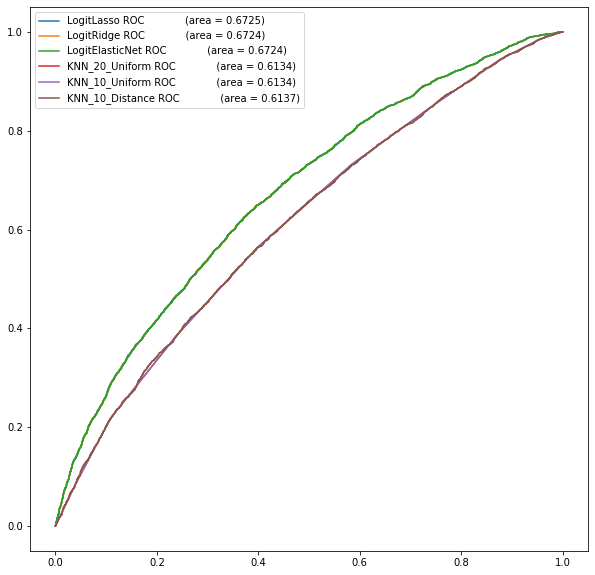

In [619]:
plt.figure(figsize = (10, 10))
for i in SCALED_ML_MODELS.keys():
    try:
        plt.plot(fpr_s[i], tpr_s[i], label = i + ' ROC \
            (area = %0.4f)' % auc_dict_s[i])
    except:
        pass
plt.legend()

## Unscaled classifiers
Based on percentage difference - use `random_state = 499` and `cv = 5` for everything

In [9]:
X2, Y2 = create_features(MLB_DF[MLB_DF.Y <= cutoff], True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
UNSCALED_ML_MODELS = {}

In [457]:
Lasso = LogisticRegressionCV(cv = 5, random_state = 499,
                               penalty='l1',
                               solver='saga',
                            max_iter = 400)
Lasso.fit(X2, Y2)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=400, multi_class='auto', n_jobs=None,
                     penalty='l1', random_state=499, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0)

In [462]:
Ridge = LogisticRegressionCV(Cs = [0.1], 
                             cv = 5, random_state = 499,
                               penalty='l2',
                               solver='saga',
                            max_iter = 400)
Ridge.fit(X2, Y2)

LogisticRegressionCV(Cs=[0.1], class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=400, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=499, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0)

In [585]:
ElasticNet = LogisticRegressionCV(Cs = [0.01], 
                                  cv = 5, random_state = 499,
                               penalty='elasticnet',
                               solver='saga',
                               l1_ratios = [0.5],
                                 max_iter = 400)
ElasticNet.fit(X2, Y2)

LogisticRegressionCV(Cs=[0.01], class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=[0.5],
                     max_iter=400, multi_class='auto', n_jobs=None,
                     penalty='elasticnet', random_state=499, refit=True,
                     scoring=None, solver='saga', tol=0.0001, verbose=0)

In [464]:
# Stochastic gradient descent
SGD = SGDClassifier(random_state = 499, 
              n_iter_no_change = 10, loss='log')
SGD.fit(X2, Y2)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=10, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=499, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [467]:
# # Decision tree
# param_grid = {
#     'criterion': ('gini', 'entropy'),
#     'max_depth': [1, 2, 3, 4, 5, 7],
#     'max_features': ['auto', 'sqrt', 'log2', None],
#     'random_state': [499]
# }
# clf = GridSearchCV(DecisionTreeClassifier(), 
#              param_grid)
# clf.fit(X2, Y2)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ('gini', 'entropy'),
                

In [468]:
# pd.DataFrame(clf.cv_results_).sort_values(
# by = 'rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
39,0.136432,0.008075,0.002766,0.000610,entropy,4,None,499,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.630423,0.612850,0.617053,0.610325,0.613483,0.616827,0.007130,1
15,0.113627,0.011554,0.002693,0.000342,gini,4,None,499,"{'criterion': 'gini', 'max_depth': 4, 'max_fea...",0.627814,0.612850,0.616916,0.610325,0.613483,0.616278,0.006140,2
35,0.111920,0.019453,0.002340,0.000222,entropy,3,None,499,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.625892,0.614498,0.618701,0.605657,0.613621,0.615674,0.006626,3
11,0.078476,0.000151,0.002234,0.000081,gini,3,None,499,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.619577,0.614498,0.618564,0.605657,0.613621,0.614383,0.004923,4
19,0.124455,0.001004,0.002408,0.000096,gini,5,None,499,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.627677,0.615733,0.608266,0.605108,0.614033,0.614163,0.007770,5


In [469]:
DT = DecisionTreeClassifier(
    random_state = 499,
    criterion = 'entropy',
    max_depth = 3,
    max_features = None
)
DT.fit(X2, Y2)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=499, splitter='best')

In [470]:
# # RandomSearc for RandomForest
# param_grid = {
#     'n_estimators': [30, 40, 50, 60],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [2, 3, 4],
#     'max_features': ['auto'],
#     'oob_score': [True],
#     'random_state': [499]
# }
# clf_rf = RandomizedSearchCV(RandomForestClassifier(), 
#              param_grid, cv=5, n_jobs = -1)
# clf_rf.fit(X2, Y2)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [471]:
# print("Optimal: ", clf_rf.best_params_)
# print("Score: ", clf_rf.best_score_)

Optimal:  {'random_state': 499, 'oob_score': True, 'n_estimators': 60, 'max_features': 'auto', 'max_depth': 4, 'criterion': 'entropy'}
Score:  0.6187767500810377


In [574]:
# Random forest
RF = RandomForestClassifier(
    n_estimators = 60, 
    max_depth = 4, 
    max_features = 'auto',
    criterion = 'entropy',
    oob_score = True,
    random_state = 499)
RF.fit(X2, Y2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=True, random_state=499, verbose=0,
                       warm_start=False)

Computer the home bias

In [465]:
home_bias = (math.exp(Logit.intercept_[0]))/(
    1 + math.exp(Logit.intercept_[0]))
print(home_bias)

0.5444007130673575


In [7]:
home_bias = 0.5444

In [15]:
xgb_model = XGBClassifier(base_score = home_bias,
                     random_state = 499,
                     n_jobs = -1)
# param_grid = {
#     'max_depth': [3, 5],
#     'learning_rate': [0.02, 0.05, 0.1, 0.15, 0.2, 0.24, 0.251],
#     'n_estimators': [15, 30, 50, 100, 200],
#     'subsample': [0.55, 0.62, 0.69, 0.76, 0.83, 0.89],
#     'cv': [5]
# }

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.001, 0.01, 0.025, 0.05, 0.08, 0.1, 0.15],
    'n_estimators': [50, 100, 200, 300, 400],
#     'subsample': [0.55, 0.62, 0.69, 0.76, 0.83, 0.89],
    'cv': [5]
}
rscv = RandomizedSearchCV(xgb_model, param_grid)
rscv.fit(X2, Y2)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5444, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=N...
                                           subsample=None, tree_method=None,
                                           validate_parameters=False,
                                           verbosity=None),
                 

In [18]:
# pd.DataFrame(rscv.cv_results_)

In [17]:
# XGBoost
XGBooster = XGBClassifier(base_score = home_bias,
            n_estimators = 15,
           max_depth = 3,
           learning_rate = 0.251,
           subsample = 0.89,                
             random_state = 499,
                     n_jobs = -1,
                          cv = 5)
XGBooster = XGBClassifier(base_score = home_bias,
            n_estimators = 300,
           max_depth = 3,
           learning_rate = 0.05,          
             random_state = 499,
                     n_jobs = -1,
                          cv = 5)
XGBooster.fit(X2, Y2)

XGBClassifier(base_score=0.5444, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, cv=5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=499, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [23]:
# Logit
UNSCALED_ML_MODELS['LogitLasso'] = Lasso
UNSCALED_ML_MODELS['LogitRidge'] = Ridge
UNSCALED_ML_MODELS['LogitElasticNet'] = ElasticNet

# SGD
UNSCALED_ML_MODELS['SGD'] = SGD

# XGBoost
UNSCALED_ML_MODELS['XGBoost'] = XGBooster

# RF
UNSCALED_ML_MODELS['DecisionTree'] = DT

# RF
UNSCALED_ML_MODELS['RF'] = RF

NameError: name 'Lasso' is not defined

Score our models and determine the output

In [28]:
UNSCALED_SCORE_DF = score_models(
    UNSCALED_ML_MODELS,
    UNSCALED_ML_RESULTS,
    MLB_FINAL_DATA_UNSCALED
)

In [29]:
UNSCALED_SCORE_DF

,LogitLasso,LogitRidge,LogitElasticNet,DecisionTree,RF,SGD,XGBoost
Y,,,,,,,
2016,0,0,0,0,0,0,0.614339
2017,0,0,0,0,0,0,0.618519
2018,0,0,0,0,0,0,0.637299
2019,0,0,0,0,0,0,0.625155


In [30]:
UNSCALED_SCORE_DF.T.max()

Y
2016    0.614339
2017    0.618519
2018    0.637299
2019    0.625155
dtype: float64

In [973]:
UNSCALED_SCORE_DF.to_csv(PATH_TO_VIS_DATA + 'unscaled_model_scores.csv')

In [590]:
UNSCALED_BRIER_DF = brier_score_models(
    UNSCALED_ML_MODELS,
    UNSCALED_ML_RESULTS,
    MLB_FINAL_DATA_UNSCALED
)

In [591]:
UNSCALED_BRIER_DF.T.min()

Y
2016    0.230019
2017    0.225924
2018    0.223644
2019    0.226753
dtype: float64

In [592]:
UNSCALED_BRIER_DF.std()

LogitLasso         0.002501
LogitRidge         0.002298
LogitElasticNet    0.002318
DecisionTree       0.003992
RF                 0.002708
SGD                0.019293
XGBoost            0.002941
dtype: float64

In [969]:
UNSCALED_BRIER_DF.to_csv(PATH_TO_VIS_DATA + 'unscaled_brier_scores.csv')

In [41]:
def score_models_monthly(MODELS_TO_TEST,
                 RESULTS_DF,
                 DATA_DF):
    # Score all models
    for i in MODELS_TO_TEST.keys():
        model = MODELS_TO_TEST[i]
        for month in RESULTS_DF.index:
            x_test = DATA_DF[month]['x']
            y_test = DATA_DF[month]['y']

            RESULTS_DF.loc[month, i] = model.score(
                x_test, y_test)
    
    return RESULTS_DF

In [42]:
MLB_MONTH_2019 = MLB_DF[MLB_DF.Y == 2019]
months = list(set(MLB_DF.M))
YEARLY_DATA = {}
for i in months:
    YEARLY_MLB = create_features(MLB_MONTH_2019[MLB_MONTH_2019.M == i])
    x = YEARLY_MLB[0]
    YEARLY_DATA[i] = {
        'x': x,
        'y': YEARLY_MLB[1]
    }

In [48]:
UNSCALED_SCORE_2019_DF = score_models_monthly(
    UNSCALED_ML_MODELS,
    UNSCALED_ML_RESULTS_MONTH,
    YEARLY_DATA
)

In [50]:
UNSCALED_SCORE_2019_DF.to_csv(PATH_TO_VIS_DATA + 'unscaled_model_monthly.csv')

In [51]:
UNSCALED_SCORE_2019_DF

,LogitLasso,LogitRidge,LogitElasticNet,DecisionTree,RF,SGD,XGBoost
M,,,,,,,
3,0,0,0,0,0,0,0.500000
4,0,0,0,0,0,0,0.590078
5,0,0,0,0,0,0,0.657767
6,0,0,0,0,0,0,0.622829
7,0,0,0,0,0,0,0.620219
8,0,0,0,0,0,0,0.631325
9,0,0,0,0,0,0,0.642857


Evaluating ROC curves

In [593]:
X3, Y3 = create_features(MLB_DF[MLB_DF.Y > cutoff], True)

In [594]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
auc_dict = {}

for i in UNSCALED_ML_MODELS.keys():
    fpr[i], tpr[i], _ = roc_curve(
    Y3, [x[1] for x in UNSCALED_ML_MODELS[i].predict_proba(X3)])
    auc_dict[i] = auc(fpr[i], tpr[i])

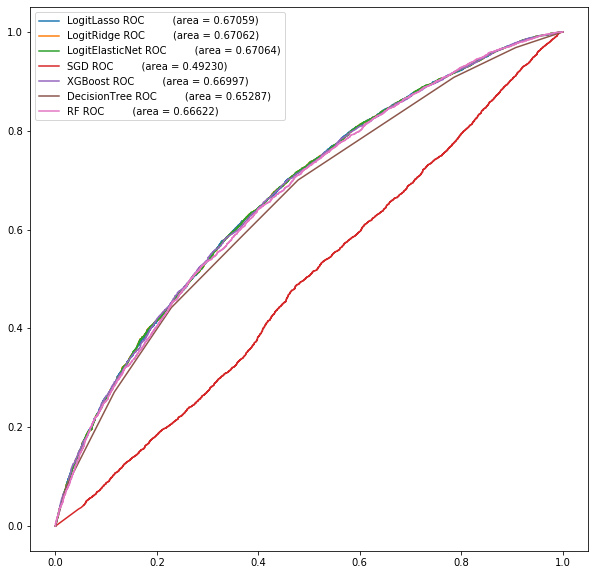

In [620]:
plt.figure(figsize = (10, 10))
for i in UNSCALED_ML_MODELS.keys():
    plt.plot(fpr[i], tpr[i], label = i + ' ROC \
        (area = %0.5f)' % auc_dict[i])
plt.legend()

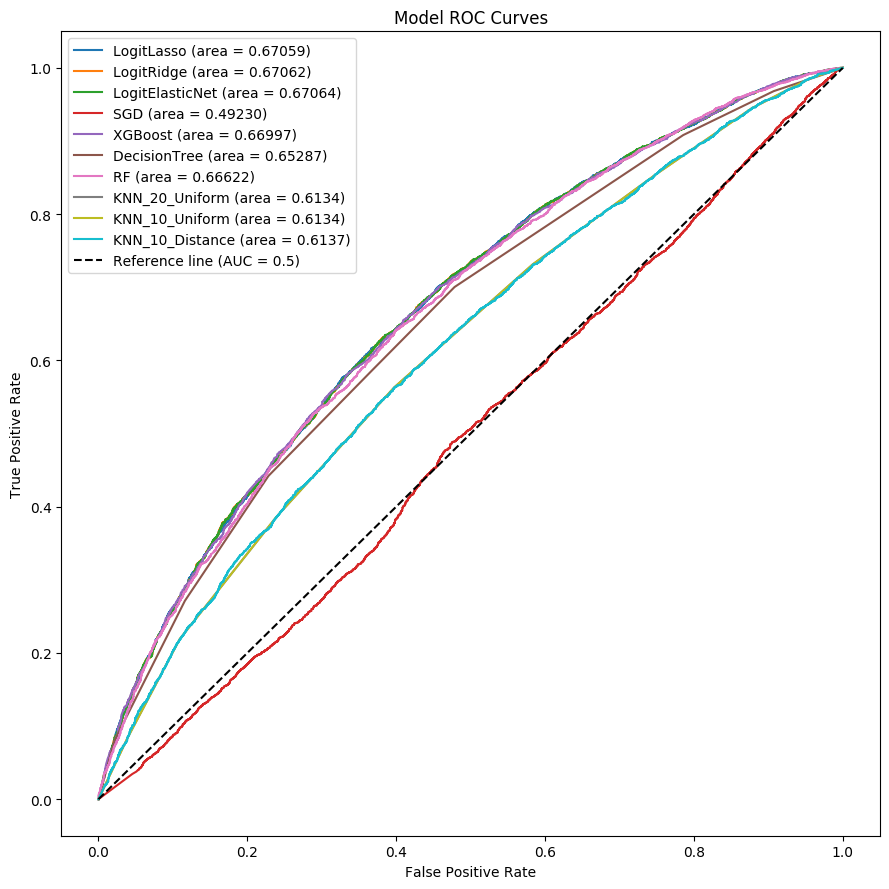

In [1083]:
plt.figure(figsize = (9, 9))
for i in UNSCALED_ML_MODELS.keys():
    plt.plot(fpr[i], tpr[i], label = i + ' (area = %0.5f)' % auc_dict[i])
for i in SCALED_ML_MODELS.keys():
    if ('Logit' not in i):
        try:
            plt.plot(fpr_s[i], tpr_s[i], label = i + ' (area = %0.4f)' % auc_dict_s[i])
        except:
            pass
plt.plot([0, 1], 'r--', color = 'black', label = 'Reference line (AUC = 0.5)')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model ROC Curves')
plt.tight_layout()
plt.savefig('../charts/model-full-roc.png', dpi=320)
plt.show()

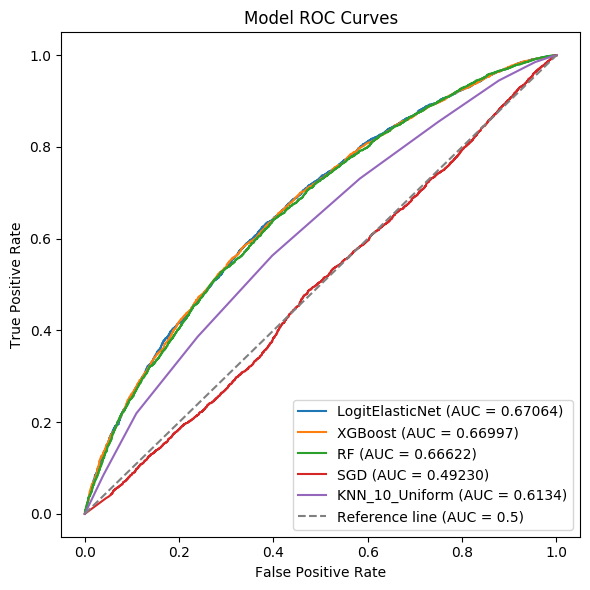

In [965]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

plt.figure(figsize = (6, 6))
for i in ['LogitElasticNet', 'XGBoost', 'RF','SGD', ]:
    plt.plot(fpr[i], tpr[i], label = i + ' (AUC = %0.5f)' % auc_dict[i])
for i in ['KNN_10_Uniform']:
    if ('Logit' not in i):
        try:
            plt.plot(fpr_s[i], tpr_s[i], label = i + ' (AUC = %0.4f)' % auc_dict_s[i])
        except:
            pass
plt.plot([0, 1], 'r--', color = 'GRAY', label = 'Reference line (AUC = 0.5)')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model ROC Curves')
plt.tight_layout()
plt.savefig('../charts/model-abbreviated-roc.png', dpi=320)
plt.show()

### Final model evaluation
Looking at ElasticNet, XGBoost, KNN, SVC_C1, Naive


Test over 2015 to 2019 modeling each season. Increased to 10 fold CV to combat overfitting

In [725]:
FINAL_MODELS = {}
# Models requiring scaling
FINAL_MODELS['KNN'] = KNeighborsClassifier(n_neighbors = 10, 
                    weights = 'uniform',
                    algorithm = 'auto')

FINAL_MODELS['SVC'] = SVC(random_state = 499,
               degree = 5, C = 0.01)

# Models not requiring scaling
FINAL_MODELS['ElasticNet'] = LogisticRegressionCV(Cs = [0.01], 
                                  cv = 10, random_state = 499,
                               penalty='elasticnet',
                               solver='saga',
                               l1_ratios = [0.5],
                                 max_iter = 1000)

FINAL_MODELS['RandomForest'] = RandomForestClassifier(
    n_estimators = 60, 
    max_depth = 4, 
    max_features = 'auto',
    criterion = 'entropy',
    oob_score = True,
    random_state = 499)

FINAL_MODELS['XGBoost'] = XGBClassifier(base_score = home_bias,
            n_estimators = 15,
           max_depth = 3,
           learning_rate = 0.251,
           subsample = 0.89,                
             random_state = 499,
                     n_jobs = -1,
                          cv = 10)

Create our response dataframes

In [726]:
MODELS_FINAL_TRAIN = pd.DataFrame([2016, 2017, 2018, 2019]).rename({
    0: 'Y'
}, axis = 1).set_index('Y')
MODELS_FINAL_TRAIN['SVC'] = 0
MODELS_FINAL_TRAIN['KNN'] = 0
MODELS_FINAL_TRAIN['ElasticNet'] = 0
MODELS_FINAL_TRAIN['RandomForest'] = 0
MODELS_FINAL_TRAIN['XGBoost'] = 0

In [727]:
MODELS_FINAL_TEST = MODELS_FINAL_TRAIN.copy()

Fit each year's data

In [728]:
# iterate over years
# , 2017, 2018, 2019
for year in [2016, 2017, 2018, 2019]:
    YEAR_MLB = MLB_DF[MLB_DF.Y == year]
    
    # Set PCT = True for non-scaled, PCT = False for scaled
    X, Y = create_features(YEAR_MLB, True)
    x_train, x_test, y_train, y_test = seasonal_train_test_split(X, Y)

    for i in ['ElasticNet', 'RandomForest', 'XGBoost']:
        model = FINAL_MODELS[i]
        model.fit(x_train, y_train)
        MODELS_FINAL_TRAIN.loc[year, i] = model.score(x_train, y_train)
        MODELS_FINAL_TEST.loc[year, i] = model.score(x_test, y_test)

In [729]:
# iterate over years
for year in [2016, 2017, 2018, 2019]:
    YEAR_MLB = MLB_DF[MLB_DF.Y == year]
    
    # Set PCT = True for non-scaled, PCT = False for scaled
    X, Y = create_features(YEAR_MLB, False)
    x_train, x_test, y_train, y_test = seasonal_train_test_split(X, Y)
    sclr = StandardScaler()
    x_train = sclr.fit_transform(x_train)
    x_test = sclr.transform(x_test)
    
    for i in ['KNN', 'SVC']:
        model = FINAL_MODELS[i]
        model.fit(x_train, y_train)
        MODELS_FINAL_TRAIN.loc[year, i] = model.score(x_train, y_train)
        MODELS_FINAL_TEST.loc[year, i] = model.score(x_test, y_test)

In [730]:
MODELS_FINAL_TRAIN

,SVC,KNN,ElasticNet,RandomForest,XGBoost
Y,,,,,
2016,0.533516,0.665385,0.618681,0.664286,0.685714
2017,0.541164,0.672887,0.643249,0.667947,0.691548
2018,0.535969,0.682043,0.640308,0.669962,0.682043
2019,0.534103,0.676568,0.628163,0.674917,0.685369


In [731]:
(MODELS_FINAL_TRAIN - MODELS_FINAL_TEST).mean()

SVC             0.001630
KNN             0.108385
ElasticNet      0.014905
RandomForest    0.054470
XGBoost         0.073824
dtype: float64

In [732]:
MODELS_FINAL_TRAIN['Naive'] = MLB_DF[MLB_DF.Y > 2015].groupby('Y')['outcome'].mean()
MODELS_FINAL_TEST['Naive'] = MLB_DF[MLB_DF.Y > 2015].groupby('Y')['outcome'].mean()

In [733]:
MODELS_FINAL_TRAIN

,SVC,KNN,ElasticNet,RandomForest,XGBoost,Naive
Y,,,,,,
2016,0.533516,0.665385,0.618681,0.664286,0.685714,0.529872
2017,0.541164,0.672887,0.643249,0.667947,0.691548,0.539506
2018,0.535969,0.682043,0.640308,0.669962,0.682043,0.527378
2019,0.534103,0.676568,0.628163,0.674917,0.685369,0.529485


In [734]:
MODELS_FINAL_TEST

,SVC,KNN,ElasticNet,RandomForest,XGBoost,Naive
Y,,,,,,
2016,0.518946,0.510708,0.599671,0.578254,0.581549,0.529872
2017,0.534539,0.580592,0.601974,0.606908,0.598684,0.539506
2018,0.557566,0.570724,0.633224,0.639803,0.628289,0.527378
2019,0.527183,0.601318,0.635914,0.634267,0.640857,0.529485


In [829]:
MODELS_FINAL_TRAIN.to_csv(PATH_TO_VIS_DATA + 'final_model_train.csv')
MODELS_FINAL_TEST.to_csv(PATH_TO_VIS_DATA + 'final_model_test.csv')

In [735]:
# iterate over years
# , 2017, 2018, 2019
for year in [2016, 2017, 2018, 2019]:
    YEAR_MLB = MLB_DF[MLB_DF.Y == year]
    
    # Set PCT = True for non-scaled, PCT = False for scaled
    X, Y = create_features(YEAR_MLB, True)
    x_train, x_test, y_train, y_test = seasonal_train_test_split(X, Y)

    for i in ['ElasticNet', 'RandomForest', 'XGBoost']:
        model = FINAL_MODELS[i]
        model.fit(x_train, y_train)
        MODELS_FINAL_TRAIN.loc[year, i] = model.score(x_train, y_train)
        MODELS_FINAL_TEST.loc[year, i] = model.score(x_test, y_test)

In [736]:
BRIER_SCORES = pd.DataFrame([2016, 2017, 2018, 2019]).rename({
    0: 'Y'
}, axis = 1).set_index('Y')
BRIER_SCORES['ElasticNet'] = 0
BRIER_SCORES['RandomForest'] = 0
BRIER_SCORES['XGBoost'] = 0

In [737]:
BRIER_NAIVE = MLB_DF[MLB_DF.Y > 2015].groupby(['Y', 'outcome'])['outcome'].count().to_frame().rename({
    'outcome': 'count'
}, axis = 1).reset_index()
BRIER_NAIVE['difference'] = (BRIER_NAIVE['count'] - BRIER_NAIVE['count'] * BRIER_NAIVE['outcome'])
BRIER_NAIVE_SCORER = BRIER_NAIVE.groupby('Y').sum()
BRIER_NAIVE_SCORER['difference']/BRIER_NAIVE_SCORER['count']

Y
2016    0.470128
2017    0.460494
2018    0.472622
2019    0.470515
dtype: float64

In [738]:
BRIER_SCORES['Naive'] = BRIER_NAIVE_SCORER['difference']/BRIER_NAIVE_SCORER['count']

In [739]:
BRIER_SCORES

,ElasticNet,RandomForest,XGBoost,Naive
Y,,,,
2016,0,0,0,0.470128
2017,0,0,0,0.460494
2018,0,0,0,0.472622
2019,0,0,0,0.470515


In [740]:
# iterate over years
# , 2017, 2018, 2019
for year in [2016, 2017, 2018, 2019]:
    YEAR_MLB = MLB_DF[MLB_DF.Y == year]
    
    # Set PCT = True for non-scaled, PCT = False for scaled
    X, Y = create_features(YEAR_MLB, True)
    x_train, x_test, y_train, y_test = seasonal_train_test_split(X, Y)

    for i in ['ElasticNet', 'RandomForest', 'XGBoost']:
        model = FINAL_MODELS[i]
        model.fit(x_train, y_train)
        BRIER_SCORES.loc[year, i] =  brier_score_loss(y_test,
                    [x[1] for x in model.predict_proba(x_test)])

In [741]:
BRIER_SCORES

,ElasticNet,RandomForest,XGBoost,Naive
Y,,,,
2016,0.230803,0.235042,0.236650,0.470128
2017,0.233752,0.232582,0.233470,0.460494
2018,0.223714,0.222452,0.226821,0.472622
2019,0.222970,0.223184,0.223082,0.470515


In [828]:
BRIER_SCORES.to_csv(PATH_TO_VIS_DATA + 'brier_scores.csv')

### Exploratory evaluation
Understanding our models

In [746]:
new_cols = ['OBP', 'WHIP', 'K9', 'HR9', 'K/BB', 'FIP', 'ISO', 'ELO', 'rest']

<BarContainer object of 9 artists>

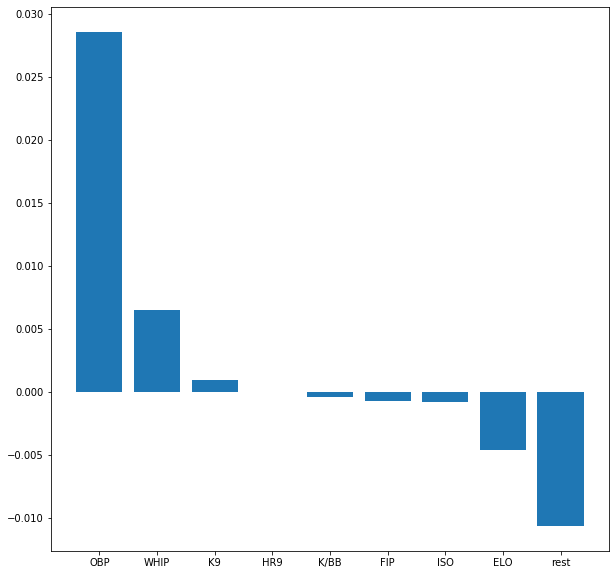

In [747]:
plt.figure(figsize = (10, 10))

plt.bar(new_cols, pd.Series(FINAL_MODELS['ElasticNet'].coef_[0], 
          index = x_train.columns).sort_values(
    ascending = False))

In [816]:
LOGIT_FI = abs(pd.Series(FINAL_MODELS['ElasticNet'].coef_[0], 
          index = new_cols)).sort_values(
ascending = False)

In [806]:
# XGBoost feature importance
XGB_FEATURES = pd.Series(FINAL_MODELS['XGBoost'].get_booster(
).get_score(
    importance_type = 'total_gain')).sort_values(
    ascending = False)
XGB_FEATURES.index = [i for i in new_cols if i != 'rest']

XGB_COLS = [i[0:4] for i in list(XGB_FEATURES.index)]

<BarContainer object of 8 artists>

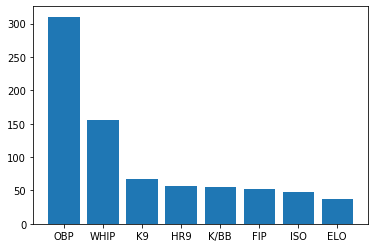

In [807]:
plt.bar(XGB_COLS,
        XGB_FEATURES)

In [808]:
XGB_FEATURES

OBP     310.235478
WHIP    155.023940
K9       67.589345
HR9      56.256752
K/BB     55.665763
FIP      51.516996
ISO      47.603709
ELO      37.499384
dtype: float64

In [812]:
XGB_FI = pd.Series(FINAL_MODELS['XGBoost'].feature_importances_,
          new_cols).sort_values(ascending = False)

In [811]:
RF_FI = pd.Series(FINAL_MODELS['RandomForest'].feature_importances_,
          new_cols).sort_values(ascending = False)

In [821]:
FI_df = pd.DataFrame([LOGIT_FI, XGB_FI, RF_FI], index = [
    'ElasticNet', 'XGBoost', 'RandomForest'
]).T

In [825]:
FI_df

,ElasticNet,XGBoost,RandomForest
OBP,0.028587,0.260696,0.334458
rest,0.010631,0.000000,0.001511
ISO,0.006530,0.160921,0.248600
WHIP,0.004617,0.082717,0.074011
K9,0.000997,0.105006,0.042547
K/BB,0.000753,0.079515,0.072443
HR9,0.000691,0.099274,0.054707
FIP,0.000410,0.098232,0.057671
ELO,0.000000,0.113638,0.114053


In [827]:
FI_df.to_csv(PATH_TO_VIS_DATA + 'feature_importance.csv')

In [974]:
from plotnine import *

### Lift charts

In [1091]:
# ONLY RUN ONCE

BRIER_TRUNCATED = BRIER_SCORES.copy()
# iterate over years
# , 2017, 2018, 2019
for year in [2016, 2017, 2018, 2019]:
    YEAR_MLB = MLB_DF[MLB_DF.Y == year]
    
    # Set PCT = True for non-scaled, PCT = False for scaled
    X, Y = create_features(YEAR_MLB, True)
    x_train, x_test, y_train, y_test = seasonal_train_test_split(X, Y)

    for i in ['ElasticNet', 'RandomForest', 'XGBoost']:
        model = FINAL_MODELS[i]
        model.fit(x_train, y_train)
        BRIER_TRUNCATED.loc[year, i] =  brier_score_loss(y_test,
                    [min(max(x[1], 0.15), 0.75) for x in model.predict_proba(x_test)])

In [1092]:
BRIER_TRUNCATED.mean()

ElasticNet      0.227428
RandomForest    0.228384
XGBoost         0.229724
Naive           0.468440
dtype: float64

In [1008]:
Lift_DF = pd.DataFrame([x[1] for x in FINAL_MODELS['RandomForest'].predict_proba(x_test)]).rename({
    0: 'RandomForest'
}, axis = 1)
Lift_DF = pd.concat([Lift_DF, pd.DataFrame([x[1] for x in FINAL_MODELS['XGBoost'].predict_proba(x_test)]).rename({
    0: 'XGBoost'
}, axis = 1),pd.DataFrame([x[1] for x in FINAL_MODELS['ElasticNet'].predict_proba(x_test)]).rename({
    0: 'ElasticNet'
}, axis = 1)], axis = 1)
Lift_DF['y'] = y_test.reset_index(drop = True)

In [1088]:
def lift_bucketing(x):
    if (x <= 0.15):
        return 0.15
    if (x >= 0.75):
        return 0.75
    return x
    
Lift_DF_bucket = Lift_DF.applymap(lambda x: lift_bucketing(round(16*x)/16))

In [1089]:
Lift_DF_bucket.groupby('ElasticNet').count()

,RandomForest,XGBoost,y
ElasticNet,,,
0.1500,15,15,15
0.1875,23,23,23
0.2500,37,37,37
0.3125,49,49,49
0.3750,46,46,46
0.4375,71,71,71
0.5000,83,83,83
0.5625,83,83,83
0.6250,82,82,82


In [1090]:
Lift_Chart = pd.concat([
    Lift_DF_bucket.groupby('ElasticNet')['y'].mean().to_frame().rename({'y': 'ElasticNet'}, axis = 1),
    Lift_DF_bucket.groupby('RandomForest')['y'].mean().to_frame().rename(
        {'y': 'RandomForest'}, axis = 1),
    Lift_DF_bucket.groupby('XGBoost')['y'].mean().to_frame().rename({
        'y': 'XGBoost'}, axis = 1)], axis = 1).fillna(0)

In [1094]:
Lift_Chart

,ElasticNet,RandomForest,XGBoost
0.1500,0.310000,0.000000,0.150000
0.1875,0.176087,0.000000,0.407143
0.2500,0.344595,0.305556,0.257692
0.3125,0.370408,0.300000,0.331579
0.3750,0.384783,0.376230,0.410377
0.4375,0.445775,0.430000,0.426000
0.5000,0.431928,0.426190,0.461111
0.5625,0.518675,0.486449,0.479032
0.6250,0.530488,0.527143,0.525904
0.6875,0.600000,0.628378,0.559091


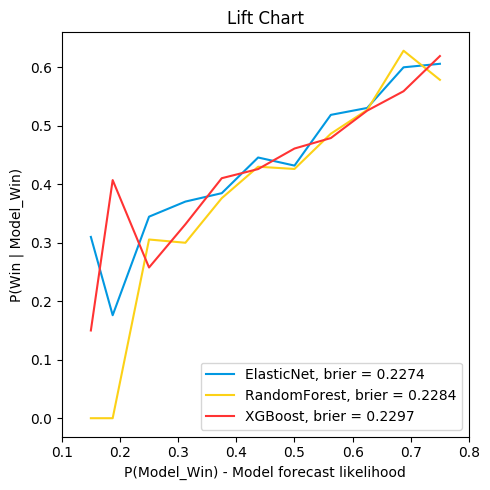

In [1115]:
plt.figure(figsize = (5, 5))
plt.plot(Lift_Chart['ElasticNet'], color = '#0198E1',
         label = 'ElasticNet, brier = %0.4f' % BRIER_TRUNCATED.mean()['ElasticNet'])
plt.plot(Lift_Chart['RandomForest'], color = '#FCD116',
         label = 'RandomForest, brier = %0.4f' % BRIER_TRUNCATED.mean()['RandomForest'])
plt.plot(Lift_Chart['XGBoost'], color = '#FF3333',
         label = 'XGBoost, brier = %0.4f' % BRIER_TRUNCATED.mean()['XGBoost'])
plt.xlim(0.1, 0.8)
plt.xlabel('P(Model_Win) - Model forecast likelihood')
plt.ylabel('P(Win | Model_Win)')
plt.title('Lift Chart')
plt.tight_layout()
plt.legend(loc = 'lower right')
plt.savefig('../charts/lift-final-truncated.png', dpi=320)

### Summative analysis

In [1126]:
nationals_df = MLB_DF[(MLB_DF.Y == 2019) & ((MLB_DF.home_team == 'WAS') | (MLB_DF.away_team == 'WAS'))]

In [1127]:
nats_features = create_features(nationals_df, True)

In [1152]:
nats_home_indicator = (nationals_df.home_team == 'WAS').astype(int).reset_index(drop = True)

In [1160]:
nats_predictions = [x[1] for x in FINAL_MODELS['ElasticNet'].predict_proba(nats_features[0])]
# (FINAL_MODELS['ElasticNet'].predict(nats_features[0]) == nats_features[1]).mean()

In [1225]:
nats_wins = 0

nats_win_probabilities = []
for i in range(162):
    if (nats_home_indicator[i] == 1):
        if (nats_predictions[i] > 0.5):
            nats_wins = nats_wins + 1
        nats_win_probabilities.append(nats_predictions[i] - 0.5)
    else:
        if (nats_predictions[i] <= 0.5):
            nats_wins = nats_wins + 1
        nats_win_probabilities.append(1 - nats_predictions[i] - 0.5)


In [1226]:
nats_wins

113

(0.0, 162.0, -0.4629822061792251, 0.5345642159056789)

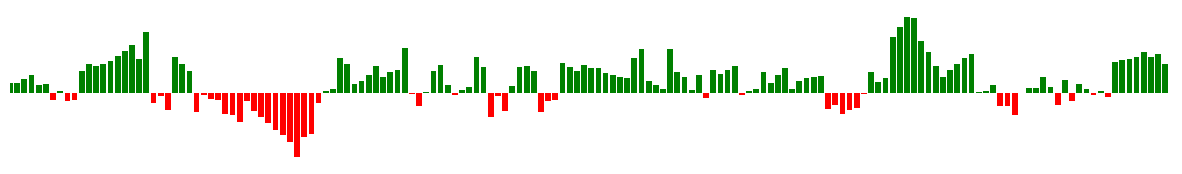

In [1191]:
plt.figure(figsize = (15, 2))
plt.bar(range(162), nats_win_probabilities, color = ['green' if x > 0 else 'red' for x in nats_win_probabilities])
plt.xlim(0, 162)
plt.savefig('../charts/2019-washington-nationals.png', dpi=320)
plt.axis('off')

For my Yankees...

In [1242]:
yanks = MLB_DF[(MLB_DF.Y == 2017) & ((MLB_DF.home_team == 'NYA') | (MLB_DF.away_team == 'NYA'))]
baby_bombers = create_features(yanks, True)
cradle = (yanks.home_team == 'NYA').astype(int).reset_index(drop = True)
yanks_2017 = [x[1] for x in FINAL_MODELS['ElasticNet'].predict_proba(baby_bombers[0])]

yankees_win = 0
nyy_win_probabilities = []
for i in range(162):
    if (cradle[i] == 1):
        if (yanks_2017[i] > 0.5):
            yankees_win = yankees_win + 1
        nyy_win_probabilities.append(yanks_2017[i] - 0.5)
    else:
        if (yanks_2017[i] <= 0.5):
            yankees_win = yankees_win + 1
        nyy_win_probabilities.append(1 - yanks_2017[i] - 0.5)
        
print(yankees_win)

99


(0.0, 162.0, -0.2693699544203793, 0.3950953883184151)

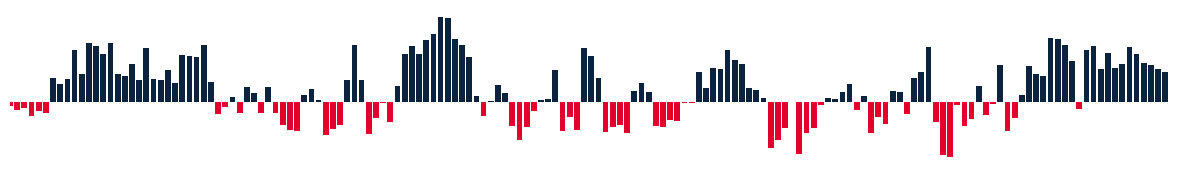

In [1243]:
plt.figure(figsize = (15, 2))
plt.bar(range(162), nyy_win_probabilities, color = ['#0C2340' if x > 0 else '#E4002C' for x in nyy_win_probabilities])
plt.xlim(0, 162)
plt.savefig('../charts/2017-newyork-yankees.png', dpi=320)
plt.axis('off')

And the unfortunate but well deserved Red Sox (Dr. Jensen's team...)

In [1199]:
Boston_Data = MLB_DF[(MLB_DF.Y == 2018) & ((MLB_DF.home_team == 'BOS') | (MLB_DF.away_team == 'BOS'))]
BOS_FEATURES = create_features(Boston_Data, True)
BOS_HOME = (Boston_Data.home_team == 'BOS').astype(int).reset_index(drop = True)
BOS_2018 = [x[1] for x in FINAL_MODELS['ElasticNet'].predict_proba(BOS_FEATURES[0])]

BOS_WIN = 0
bos_win_probabilities = []
for i in range(162):
    if (BOS_HOME[i] == 1):
        if (BOS_2018[i] > 0.5):
            BOS_WIN = BOS_WIN + 1
        bos_win_probabilities.append(BOS_2018[i] - 0.5)
    else:
        if (BOS_2018[i] <= 0.5):
            BOS_WIN = BOS_WIN + 1
        bos_win_probabilities.append(1 - BOS_2018[i] - 0.5)
        
print(BOS_WIN)

116


(0.0, 162.0, -0.33381980711173304, 0.3974695804447593)

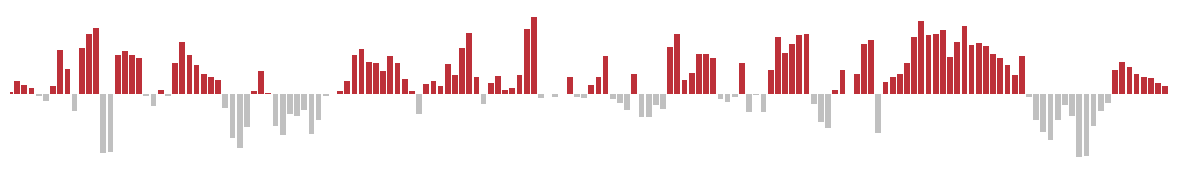

In [1221]:
plt.figure(figsize = (15, 2))
plt.bar(range(162), bos_win_probabilities, color = ['#BD3039' if x > 0 else 'silver' for x in bos_win_probabilities])
plt.xlim(0, 162)
plt.savefig('../charts/2018-boston-redsox.png', dpi=320)
plt.axis('off')

Cleveland Indians

108


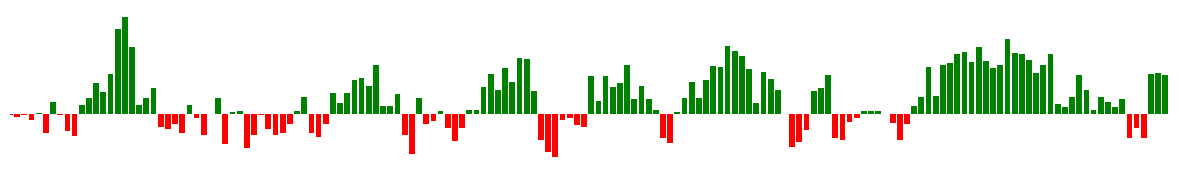

In [1205]:
Boston_Data = MLB_DF[(MLB_DF.Y == 2017) & ((MLB_DF.home_team == 'CLE') | (MLB_DF.away_team == 'CLE'))]
BOS_FEATURES = create_features(Boston_Data, True)
BOS_HOME = (Boston_Data.home_team == 'CLE').astype(int).reset_index(drop = True)
BOS_2018 = [x[1] for x in FINAL_MODELS['ElasticNet'].predict_proba(BOS_FEATURES[0])]

BOS_WIN = 0
bos_win_probabilities = []
for i in range(162):
    if (BOS_HOME[i] == 1):
        if (BOS_2018[i] > 0.5):
            BOS_WIN = BOS_WIN + 1
        bos_win_probabilities.append(BOS_2018[i] - 0.5)
    else:
        if (BOS_2018[i] <= 0.5):
            BOS_WIN = BOS_WIN + 1
        bos_win_probabilities.append(1 - BOS_2018[i] - 0.5)
        
print(BOS_WIN)
plt.figure(figsize = (15, 2))
plt.bar(range(162), bos_win_probabilities, color = ['green' if x > 0 else 'red' for x in bos_win_probabilities])
plt.xlim(0, 162)
plt.axis('off')
plt.xlabel('Cleveland Indians, 2017')
plt.savefig('../charts/2017-cleveland-indians.png', dpi=320)


104


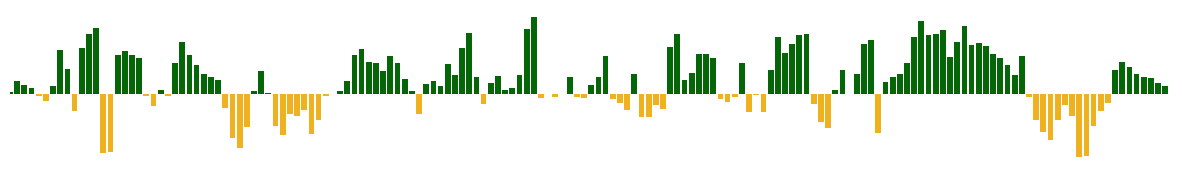

In [1224]:
# OAKLAND A'S
Boston_Data = MLB_DF[(MLB_DF.Y == 2002) & ((MLB_DF.home_team == 'OAK') | (MLB_DF.away_team == 'OAK'))]
BOS_FEATURES = create_features(Boston_Data, True)
BOS_HOME = (Boston_Data.home_team == 'OAK').astype(int).reset_index(drop = True)
BOS_2018 = [x[1] for x in FINAL_MODELS['ElasticNet'].predict_proba(BOS_FEATURES[0])]

BOS_WIN = 0
bos_win_probabilities = []
for i in range(162):
    if (BOS_HOME[i] == 1):
        if (BOS_2018[i] > 0.5):
            BOS_WIN = BOS_WIN + 1
        bos_win_probabilities.append(BOS_2018[i] - 0.5)
    else:
        if (BOS_2018[i] <= 0.5):
            BOS_WIN = BOS_WIN + 1
        bos_win_probabilities.append(1 - BOS_2018[i] - 0.5)
        
print(BOS_WIN)
plt.figure(figsize = (15, 2))
plt.bar(range(162), bos_win_probabilities, color = ['#056607' if x > 0 else '#EFB21E' for x in bos_win_probabilities])
plt.xlim(0, 162)
plt.axis('off')
plt.xlabel('Oakland As, 2002 - Moneyball')
plt.savefig('../charts/2002-oakland-as.png', dpi=320)


### Analysis of the 2019 season to compare to Pythagorean

In [1279]:
team_records = pd.DataFrame(list(set(MLB_DF.home_team))).rename(
    {0: 'team'}, axis = 1
).set_index('team')
team_records[2019] = 0

In [1280]:
for team in list(set(MLB_DF.home_team)):
    TEAM_DATA = MLB_DF[(MLB_DF.Y == 2019) & ((MLB_DF.home_team == team) | (MLB_DF.away_team == team))]
    FEATURES = create_features(TEAM_DATA, True)
    HOME_TEAM = (TEAM_DATA.home_team == team).astype(int).reset_index(drop = True)
    TEAM_2019 = [x[1] for x in FINAL_MODELS['ElasticNet'].predict_proba(FEATURES[0])]

    WIN = 0
    for i in range(162):
        try:
            if (HOME_TEAM[i] == 1):
                if (TEAM_2019[i] > 0.5):
                    WIN = WIN + 1
            else:
                if (TEAM_2019[i] <= 0.5):
                    WIN = WIN + 1
        except:
            pass
    team_records.loc[team, 2019] = WIN
    print(team + ' ' + str(WIN))

BAL 36
CHA 54
SLN 75
HOU 131
BOS 109
DET 33
MIN 106
PIT 63
SDN 63
ATL 106
MIA 26
TEX 73
CIN 76
WAS 113
NYA 115
KCA 41
ANA 78
TBA 107
COL 77
CLE 103
ARI 79
CHN 99
PHI 81
OAK 97
TOR 57
SEA 65
NYN 97
SFN 62
MIL 75
LAN 128


In [1286]:
actual_records = pd.read_csv(
    PATH_TO_OUTPUT_DATA + 'EDA/W_L_DATA.csv')
actual_records = actual_records[actual_records.Y == 2019]
actual_res = actual_records.sort_values(
    by = "W",ascending = False)[['team', 'W']].set_index('team')
actual_res = actual_res.reset_index(
).reset_index().set_index('team')
actual_res['actual_rank'] = actual_res['index'] + 1

In [1287]:
pred_records = team_records.sort_values(
    by = 2019,ascending = False).reset_index(
).reset_index().set_index('team')
pred_records['pred_rank'] = pred_records['index'] + 1

In [1304]:
comparison = pd.concat([
    pred_records,
    actual_res], axis = 1)[[2019, 'W', 
                            'pred_rank', 'actual_rank']]
comparison.rename({
    2019: 'pred_win',
    'W': 'actual_win'
}, axis = 1, inplace = True)
comparison = comparison.sort_values(
    by = 'actual_win', ascending = False)
comparison.to_csv(PATH_TO_VIS_DATA + 'WL_comparison.csv')
comparison

<ipython-input-1304-09238f184377>:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  comparison = pd.concat([


,pred_win,actual_win,pred_rank,actual_rank
HOU,131,107,1,1
LAN,128,106,2,2
NYA,115,103,3,3
MIN,106,101,7,4
ATL,106,97,8,5
TBA,107,96,6,6
OAK,97,96,11,7
WAS,113,93,4,8
CLE,103,93,9,9
SLN,75,90,18,10


In [1293]:
comparison['SqErr'] = (
    comparison['pred_win'] -
    comparison['actual_win']
)**2

In [1300]:
MSE = sum(comparison['SqErr'])/30
MSE

200.73333333333332

In [1303]:
import numpy as np
np.sqrt(MSE)

14.168039149202452